#### AdaptiveRAG

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI



embedding_model=OpenAIEmbeddings(model='text-embedding-3-small')
llm=ChatOpenAI(model='gpt-4o-mini')

urls=[
    'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/',
    'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/',
    'https://lilianweng.github.io/posts/2024-07-07-hallucination/'
]


docs=[WebBaseLoader(url).load() for url in urls ]
docs_list=[item for sublist in docs for item in sublist]

text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500,
                                                                   chunk_overlap=0)

docs_split=text_splitter.split_documents(docs_list)


vector_store=FAISS.from_documents(
    documents=docs_split,
    embedding=embedding_model
)

retriever=vector_store.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [58]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel,Field


class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasources."""
    datasources:Literal['vector_store','web_search']=Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore."
    )

structured_llm_router=llm.with_structured_output(RouteQuery)

system = """
You are an expert at routing a user question to a vectorstore or web search.
- Route to 'vector_store' if the question is about:
  - prompt engineering
  - prompting techniques
  - LLM hallucination
  - adversarial attacks
- Otherwise, route to 'web_search'.
"""

route_prompt=ChatPromptTemplate.from_messages(
    [
        ('system',system),
        ('human','{question}'),
    ]
)


question_router=route_prompt|structured_llm_router

print(
    question_router.invoke(
        {"question":"For which club ronaldo plays?"}
    )
)

datasources='web_search'


In [59]:
print(
    question_router.invoke(
        {"question":"Prompting techniques?"}
    )
)

datasources='vector_store'


In [60]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score:str=Field(
        description="Document are relevant to the question,'yes' or 'no'"
        
    )

structured_llm_grader=llm.with_structured_output(GradeDocuments)

system="You are a grader assessing relevance of a retrieved document to a user question.\n" \
"if the document contains keyword(s) or semantic meaning related to the user question,grade it as relevant.\n" \
"it does not need to be stringent test.the goal is to filter out errorneous retrievals.\n" \
"give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."

grade_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","Retrieved document:\n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader=grade_prompt|structured_llm_grader
question="Prompting techniques"
docs=retriever.invoke(question)
doc_text=docs[1].page_content
print(retrieval_grader.invoke({'question':question,'document':doc_text}))

binary_score='yes'


In [61]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt=hub.pull('rlm/rag-prompt')

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain=prompt|llm|StrOutputParser()

generation=rag_chain.invoke({'context':docs,'question':question})
print(generation)

Prompting techniques, also known as Prompt Engineering or In-Context Prompting, involve methods to effectively communicate with language models (LLMs) to guide their behavior without altering the model weights. Two basic approaches are zero-shot and few-shot learning; zero-shot relies on providing the task text directly, while few-shot gives high-quality demonstrations to improve understanding. Advanced techniques include Chain-of-Thought prompting and Self-Ask methods that utilize iterative questioning for deeper reasoning processes.


In [62]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""
    binary_score:str=Field(
        description="Answer is grounded in the facts,'yes' or 'no' "
    )

structured_llm_grader=llm.with_structured_output(GradeHallucinations)

system="""You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.\n
give a binary score 'yes' or 'no'. 'yes' means the answer is grounded in / supported by the set of facts."""

hallucination_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader=hallucination_prompt|structured_llm_grader
hallucination_grader.invoke({'documents':docs,'generation':generation})

GradeHallucinations(binary_score='yes')

In [63]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score:str=Field(
        description="Answer addresses the question, 'yes' or 'no' "
    )


structured_llm_grader=llm.with_structured_output(GradeAnswer)

system="""You are a grader assessing whether an answer addresses/resolves a question \n
Give a binary score 'yes' or 'no'. 'Yes' means the answer resolves the question."""

answer_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","user question:\n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader=answer_prompt|structured_llm_grader
answer_grader.invoke({'question':question,'generation':generation})

GradeAnswer(binary_score='yes')

In [64]:
system="""You are a re-writer that converts an input question to a better version that is optimized
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent/meaning."""

re_write_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",system),
        (
            "human",
            "here is the initial question:\n\n{question} \n Formulate an improved question."
        )
    ]
)

question_rewriter=re_write_prompt|llm|StrOutputParser()
question_rewriter.invoke({'question':question})

'What are effective prompting techniques for enhancing communication and engagement?'

In [65]:
from langchain.tools.tavily_search import TavilySearchResults

web_search_tool=TavilySearchResults(k=1)


In [66]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question:str
    generation:str
    documents:List[str]

In [67]:
from langchain.schema import Document

def retrieve(state):
    print("--RETRIEVE--")
    question=state['question']

    documents=retriever.invoke(question)
    return {'documents':documents,'question':question}


def generate(state):
    print("--GENERATE--")
    question=state['question']
    documents=state['documents']

    generation=rag_chain.invoke({'context':documents,'question':question})
    return {'documents':documents,'question':question,'generation':generation}


def grade_document(state):
    print("--CHECK DOCUMENT RELEVANCE TO QUESTION--")
    question=state['question']
    documents=state['documents']


    filtered_docs=[]
    for document in documents:
        score=retrieval_grader.invoke(
            {'question':question,'document':document.page_content}
        )
        grade=score.binary_score
        if grade=='yes':
            print("--GRADE:DOCUMENT RELEVANT--")
            filtered_docs.append(documents)
        else:
            print("--GRADE:DOCUMENT NOT RELEVANT")
            continue
    return {'documents':filtered_docs,'question':question}
    
    
def transform_query(state):
    print("--TRANSFORM QUERY--")
    question=state['question']
    documents=state['documents']

    better_question=question_rewriter.invoke({'question':question})
    return {'documents':documents,'question':better_question}


def web_search(state):
    print("--WEB SEARCH--")
    question=state['question']
    docs=web_search_tool.invoke({'query':question})
    web_results="\n".join([document['content'] for document in docs])
    web_results=Document(page_content=web_results)

    return {'documents':web_results,"question":question}


def route_question(state):
    question=state['question']
    source=question_router.invoke({'question':question})
    if source.datasources=='web_search':
        print("--ROUTE QUESTION TO WEB-SEARCH--")
        return "web_search"
    elif source.datasources=="vector_store":
        print("--ROUTE QUESTION TO RAG--")
        return "vector_store"
    return "web_search"
    

def decide_to_generate(state):
    print("--ASSESS GRADED DOCUMENTS--")
    state['question']
    filtered_douments=state['documents']

    if not filtered_douments:
        print("--DECISION:ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION,TRANSFORM QUERY--")
        return "transform_query"
    else:
        print("--DECISION:GENERATE--")
        return "generate"
    

def grade_generation_v_document_and_question(state):
    print("--CHECK HALLUCINATIONS--")
    question=state['question']
    documents=state['documents']
    generation=state['generation']

    score=hallucination_grader.invoke(
        {'documents':documents,'generation':generation}
    )
    grade=score.binary_score

    if grade=="yes":
        print("--DECISION: GENERATION IS GROUNDED IN DOCUMENTS--")
        print("--GRADE GENERATIONvsQUESTION--")
        score=answer_grader.invoke({'question':question,'generation':generation})
        grade=score.binary_score
        if grade=="yes":
            print("--DECISION:GENERATION ADDRESSES QUESTION--")
            return "useful"
        else:
            print("--DECISION: GENERATION DOES NOT ADDRESS QUESTION--")
            return "not useful"
    else:
        print("--DECISION:GENERATION IS NOT GROUNDED IN DOCUMENTS,RE-TRY--")
        return "not supported"

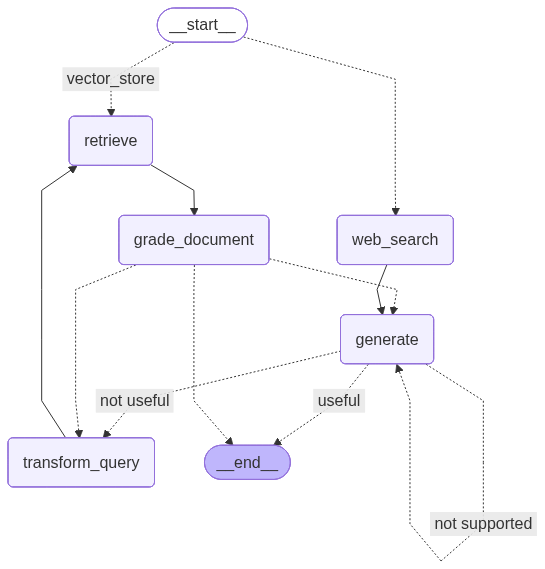

In [68]:
from langgraph.graph import START,END,StateGraph

workflow=StateGraph(GraphState)

workflow.add_node("web_search",web_search)
workflow.add_node('retrieve',retrieve)
workflow.add_node('grade_document',grade_document)
workflow.add_node('generate',generate)
workflow.add_node('transform_query',transform_query)

workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search":"web_search",
        "vector_store":"retrieve"
    },
)
workflow.add_edge('web_search','generate')
workflow.add_edge('retrieve','grade_document')
workflow.add_conditional_edges(
    "grade_document",
    decide_to_generate,
    {
        "transform_query":"transform_query",
        "generate":"generate"
    },
)
workflow.add_edge("transform_query","retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_document_and_question,
    {
        "not supported":'generate',
        'useful':END,
        "not useful":"transform_query"
    },
)

app=workflow.compile()

app

In [29]:
app.invoke({'question':'Who won the uefa champions league 2025?'})

--ROUTE QUESTION TO WEB-SEARCH--
--WEB SEARCH--
--GENERATE--
--CHECK HALLUCINATIONS--
--DECISION: GENERATION IS GROUNDED IN DOCUMENTS--
--GRADE GENERATIONvsQUESTION--
--DECISION:GENERATION ADDRESSES QUESTION--


{'question': 'Who won the uefa champions league 2025?',
 'generation': "Paris Saint-Germain won the 2025 UEFA Champions League final, defeating Inter Milan 5-0. This victory marked PSG's first Champions League title in history. The match took place at the Allianz Arena in Munich on May 31, 2025.",
 'documents': Document(metadata={}, page_content='About Us\n Careers\n Privacy Preferences\n Terms of Use\n Privacy Policy\n Cookie Policy\n\n# Who won the UEFA Champions League final 2025? How PSG made history with stunning victory over Inter Milan\n\nJoe Wright\n\n•\n\nParis Saint-Germain and Inter Milan locked horns in the final of the UEFA Champions League in 2025.\n\nThe Nerazzurri were in their second final in three seasons and hoping to do better than they did in 2023, when they lost 1-0 to Manchester City in Istanbul. [...] Treble-chasing PSG were hoping to win the trophy for the first time in their history and cap an impressive season under Luis Enrique.\n\nWhat transpired was one of

In [69]:
app.invoke({'question':'Just list the Prompting Techniques?'})

--ROUTE QUESTION TO RAG--
--RETRIEVE--
--CHECK DOCUMENT RELEVANCE TO QUESTION--
--GRADE:DOCUMENT RELEVANT--
--GRADE:DOCUMENT RELEVANT--
--GRADE:DOCUMENT RELEVANT--
--GRADE:DOCUMENT RELEVANT--
--ASSESS GRADED DOCUMENTS--
--DECISION:GENERATE--
--GENERATE--
--CHECK HALLUCINATIONS--
--DECISION: GENERATION IS GROUNDED IN DOCUMENTS--
--GRADE GENERATIONvsQUESTION--
--DECISION:GENERATION ADDRESSES QUESTION--


{'question': 'Just list the Prompting Techniques?',
 'generation': 'The prompting techniques include Basic Prompting (Zero-Shot and Few-Shot), Instruction Prompting (Self-Consistency Sampling and Chain-of-Thought), and Automatic Prompt Design. Additional methods like Self-Ask and Tree of Thoughts are also notable. Lastly, techniques involving external APIs and retrieval mechanisms can enhance prompting in specific contexts.',
 'documents': [[Document(id='aaf8a8b9-bf8e-4afa-aec4-705adc1c03f5', metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log", 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only f

In [57]:
app.invoke({'question':'Why LLM hallucinates?'})

--ROUTE QUESTION TO RAG--
--RETRIEVE--
--CHECK DOCUMENT RELEVANCE TO QUESTION--
--GRADE:DOCUMENT RELEVANT--
--GRADE:DOCUMENT RELEVANT--
--GRADE:DOCUMENT RELEVANT--
--GRADE:DOCUMENT RELEVANT--
--ASSESS GRADED DOCUMENTS--
--DECISION:GENERATE--
--GENERATE--
--CHECK HALLUCINATIONS--
--DECISION: GENERATION IS GROUNDED IN DOCUMENTS--
--GRADE GENERATIONvsQUESTION--
--DECISION:GENERATION ADDRESSES QUESTION--


{'question': 'Why LLM hallucinates?',
 'generation': "LLMs hallucinate due to the inherent issues in their vast pre-training datasets, which often contain outdated, missing, or incorrect information. During fine-tuning, introducing new knowledge can exacerbate the model's tendency to generate ungrounded or fabricated responses, especially when the model learns these examples slower than others. As a result, LLMs may provide answers that are inconsistent with factual information or external world knowledge.",
 'documents': [[Document(id='be6f2e3b-1bed-4e10-a4f8-156589a744f0', metadata={'source': 'https://lilianweng.github.io/posts/2024-07-07-hallucination/', 'title': "Extrinsic Hallucinations in LLMs | Lil'Log", 'description': 'Hallucination in large language models usually refers to the model generating unfaithful, fabricated, inconsistent, or nonsensical content. As a term, hallucination has been somewhat generalized to cases when the model makes mistakes. Here, I would like to narrow